<a href="https://colab.research.google.com/github/WinetraubLab/roi-classification-foundation-model/blob/main/compute_uni_heatmap.ipynb" target="_blank">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>
  
<a href="https://github.com/WinetraubLab/roi-classification-foundation-model/blob/main/compute_uni_heatmap.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/view%20in-GitHub-blue" alt="View in GitHub"/>
</a>

# Overview
This notebook will compute similarity heatmap between quarry patch and test image using [UNI](https://www.nature.com/articles/s41591-024-02857-3).


In [10]:
# @title Script Inputs

# Input images - VH&E
#test_image_file_path = "/content/drive/Shareddrives/Yolab - Current Projects/Kyi Lei Aye/UNI_Model/Figure S4/FigureS4_c.jpg"
#query_patch_file_path = "/content/drive/Shareddrives/Yolab - Current Projects/Kyi Lei Aye/UNI_Model/Ref_images/6_i_resized.png"

# Input images - OCT
test_image_file_path = "/content/drive/Shareddrives/Yolab - Current Projects/Kyi Lei Aye/UNI_Model/Figure S4/FigureS4_a.jpg"
query_patch_file_path = "/content/drive/Shareddrives/Yolab - Current Projects/Kyi Lei Aye/UNI_Model/Ref_images/6_c_resized.png"

model_name = 'resnet50' # Set to "uni" or "resnet50"

In [11]:
# @title Environment Setup

if not 'setup_env' in globals():
  setup_env = True

  # Mount drive
  from google.colab import drive
  drive.mount('/content/drive')

  # Clone repository
  !git clone --recurse-submodules https://github.com/WinetraubLab/roi-classification-foundation-model/
  %cd ./roi-classification-foundation-model/

  # Install all requirements
  !pip install -r requirements.txt

# Imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from uni_score import UNIScore
from resnet50_score import Resnet50Score
from my_heatmap import get_patch_from_image
from tqdm import tqdm
from scipy.interpolate import griddata

if model_name == "uni":
  # Boot up UNI
  model = UNIScore()
elif model_name == "resnet50":
  # Boot up ResNet-50
  model = Resnet50Score()
else:
  raise RuntimeError(f"Unknown model name: {model_name}")

Query Patch:


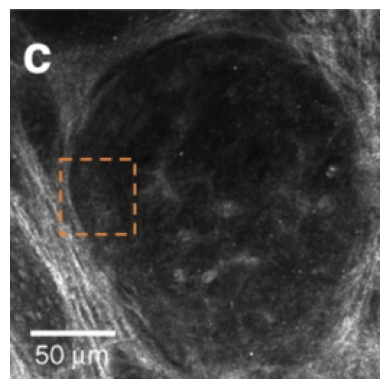

  0%|          | 0/2 [00:00<?, ?it/s]

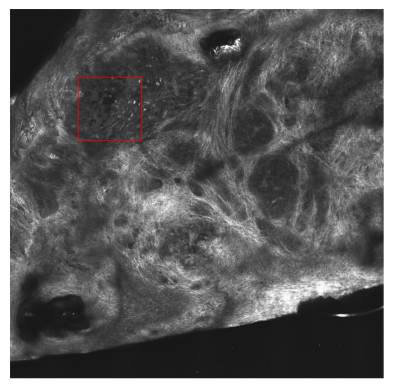

Healthy Score is 0.643


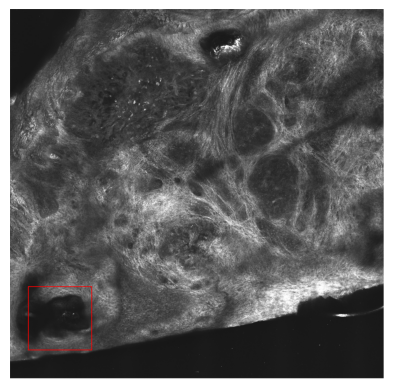

  0%|          | 0/2 [00:00<?, ?it/s]


Healthy Score is 0.671


  0%|          | 0/3 [00:00<?, ?it/s]

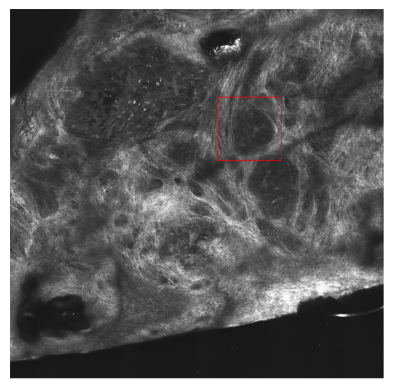

BCC Score is 0.763


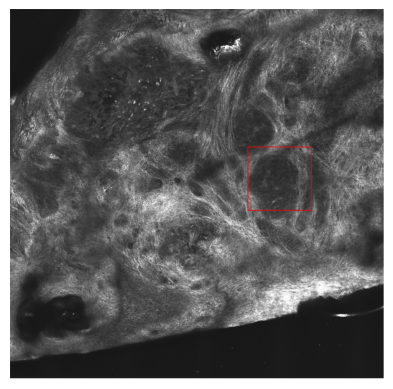

BCC Score is 0.741


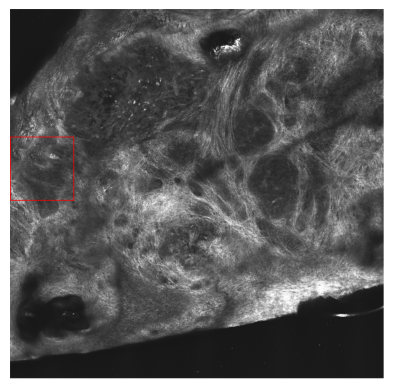

  0%|          | 0/3 [00:01<?, ?it/s]

BCC Score is 0.696


In [12]:
# @title Compute Selected Patch Scores

# Open the images
test_image = Image.open(test_image_file_path).convert("RGB")
f = 0.8
test_image = test_image.resize((int(test_image.size[0]*f), int(test_image.size[1]*f)))
query_patch = Image.open(query_patch_file_path).convert("RGB")

# Show query patch
print("Query Patch:")
plt.imshow(query_patch)
plt.axis('off')  # Hide axes for better visibility
plt.show()
query_emb = model.compute_patch_embedding(query_patch)

healthy_points=np.round(np.array([
    [500, 500],
    [250, 1550],
    ])*f)

bcc_points = np.round(np.array([
  [1200, 600],
  [1350, 850],
  [160, 800],
  ])*f)

def compute_scores(points, points_type, color, plot_patch_over_image):
  scores = np.zeros((points.shape[0],1))
  with tqdm(total=len(scores)) as pbar:
    for i in range(0,len(scores)):
      patch = get_patch_from_image(test_image, points[i,0], points[i,1], plot_patch_over_image = plot_patch_over_image);
      patch_emb = model.compute_patch_embedding(patch)
      score = model.compute_similarity_between_embeddings(patch_emb, query_emb)
      scores[i] = score
      if plot_patch_over_image:
        print(f"{points_type} Score is {score:.3f}")
      else:
        pbar.update(1)
  return scores

healthy_scores = compute_scores(healthy_points,'Healthy','blue',True)
bcc_scores = compute_scores(bcc_points,'BCC','red',True)



In [13]:
# Grid points
grid_jump = 64
grid_y, grid_x = np.mgrid[128:(test_image.size[0]-128):grid_jump, 128:(test_image.size[1]-128):grid_jump]
grid_points = np.vstack((grid_x.flatten(),grid_y.flatten())).T

grid_scores = compute_scores(grid_points,'','',False)


100%|██████████| 400/400 [01:37<00:00,  4.11it/s]


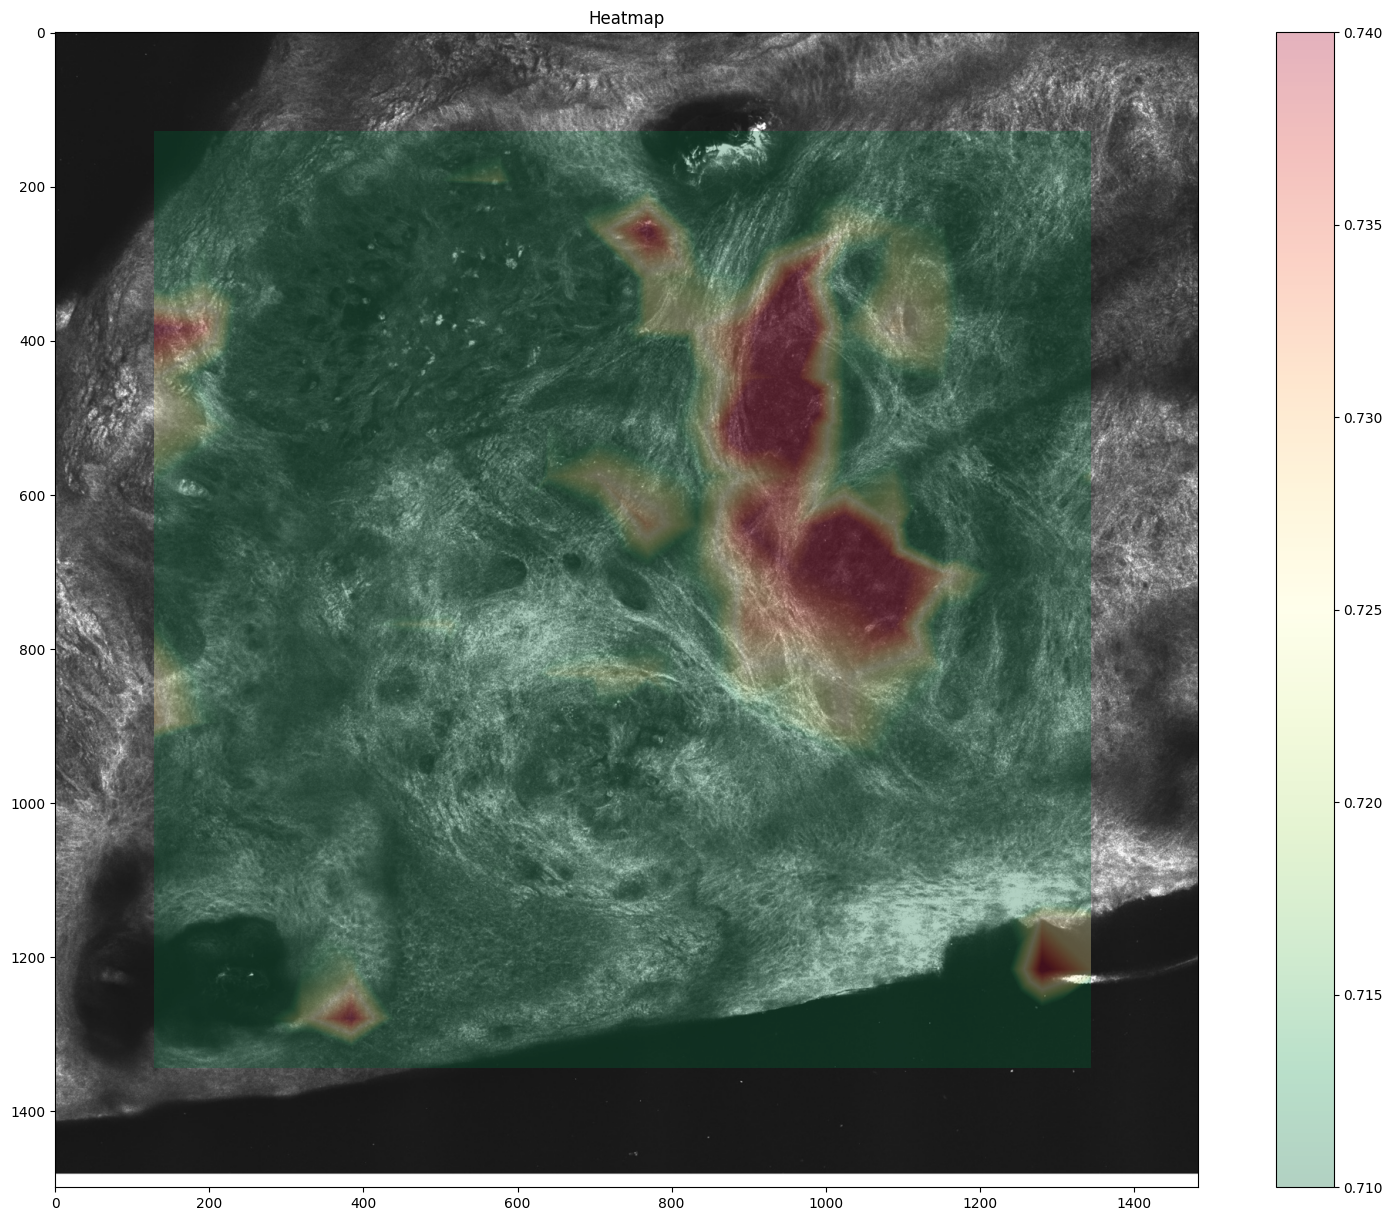

[[0.64316696]
 [0.67145276]]
[[0.76302433]
 [0.74130571]
 [0.69597393]]


In [18]:
# @title Heatmap

# Create a hitmap grid an interpolate for the images we have
grid_y, grid_x = np.mgrid[0:test_image.size[0], 0:test_image.size[1]]
interp_scores = griddata(
    np.vstack((healthy_points, bcc_points, grid_points)),
    np.vstack((healthy_scores, bcc_scores, grid_scores)), (grid_x, grid_y), method='linear')

# Plot the heatmap overlay on the image
fig, ax = plt.subplots(figsize=(20, 15))
ax.imshow(test_image)

# Create a heatmap
cax = ax.imshow(interp_scores, cmap='RdYlGn_r', alpha=0.3)

# Add color bar and limit according to healthy and desies tissue
plt.colorbar(cax, ax=ax)
min_c = 0.71 # np.percentile(healthy_scores,80)
max_c = 0.74 # np.percentile(bcc_scores,20)
cax.set_clim((min_c,max_c))

# Show the plot
plt.title('Heatmap')
plt.show()
print(healthy_scores)
print(bcc_scores)

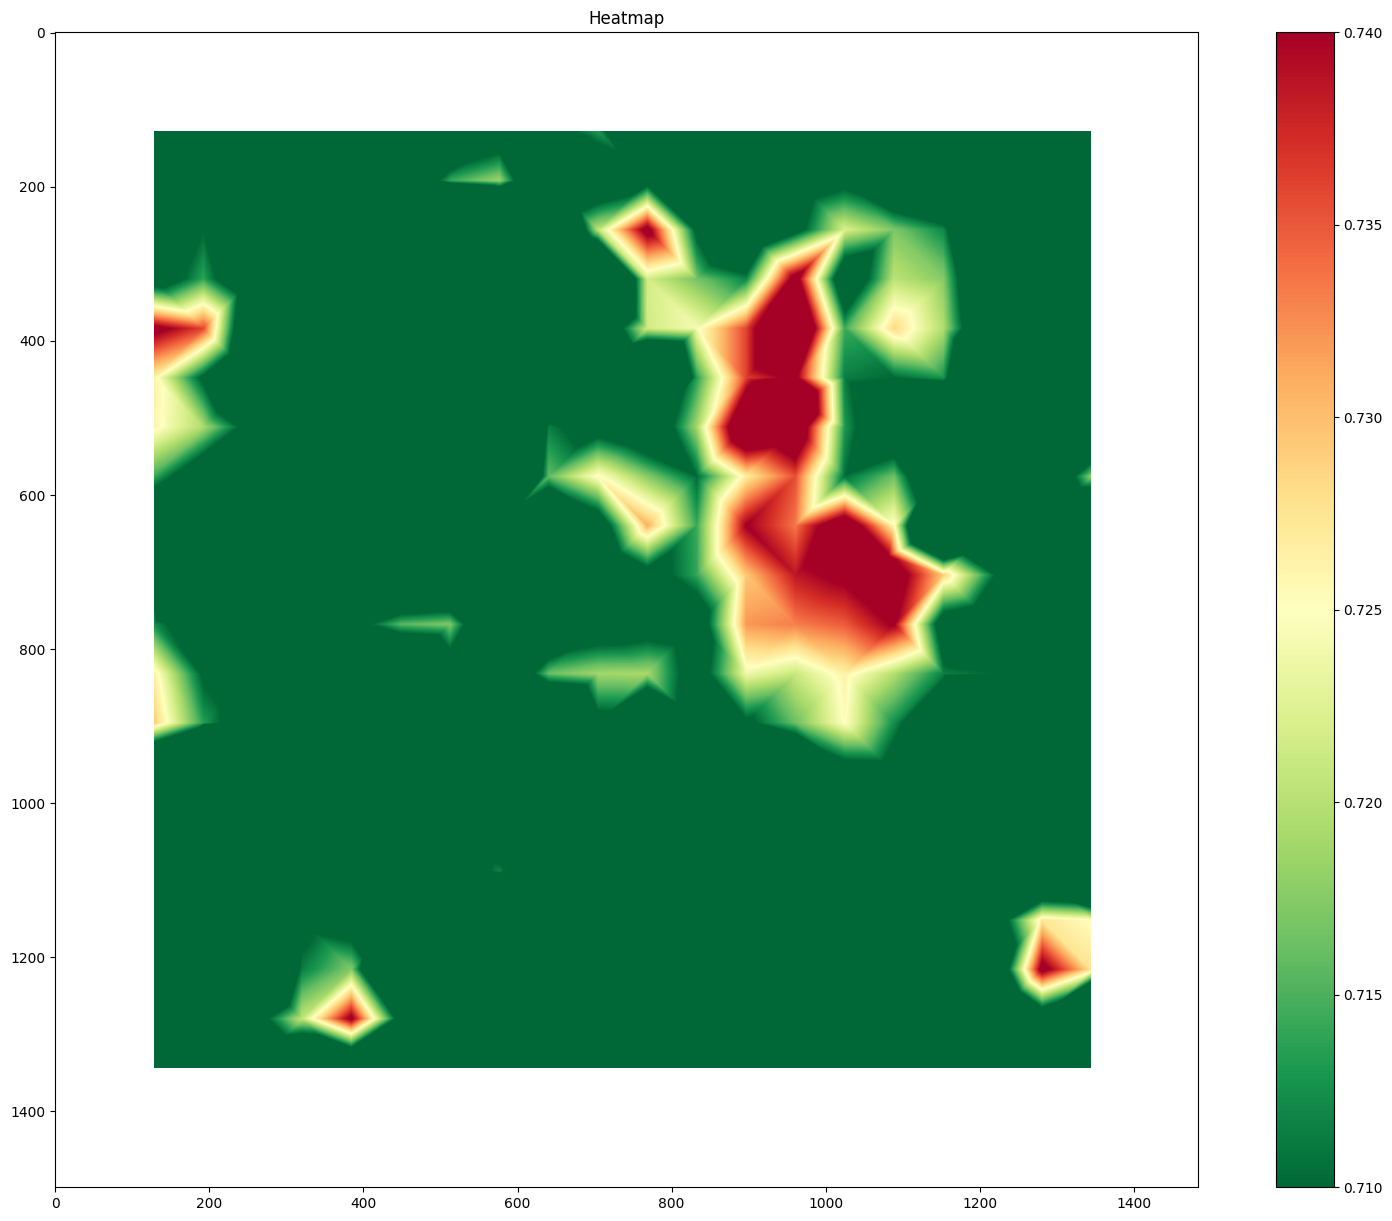

In [19]:
# @title Heatmap (no overlay)

# Plot the heatmap overlay on the image
fig, ax = plt.subplots(figsize=(20, 15))

# Create a heatmap
cax = ax.imshow(interp_scores, cmap='RdYlGn_r')

# Add color bar and limit according to healthy and desies tissue
plt.colorbar(cax, ax=ax)
cax.set_clim((min_c,max_c))

# Show the plot
plt.title('Heatmap')
plt.show()